# Data exploration and visualization for the soil metagenomes (DP1.10107.001) NEON study

This notebook explores how soil pH changes with time for the 47 sites part of the NEON study. It also examines how the average water_content changes by season for each site.

In [1]:
# Load essential libraries
library(jsonlite, warn.conflicts=FALSE)
library(dplyr, warn.conflicts=FALSE)
library(tidyr, warn.conflicts=FALSE)
library(ggplot2, warn.conflicts=FALSE)
library(forcats, warn.conflicts=FALSE)
library(lubridate, warn.conflicts=FALSE)
if (!require('maps', quiet = TRUE)) install.packages('maps', quiet = TRUE); library('maps', warn.conflicts=FALSE)

## Get study IDs associated with NEON sites using NMDC runtime API

Using R's jsonlite package and the [NMDC studies find endpoint](https://api.microbiomedata.org/docs#/find/find_studies_studies_get), we can get the NMDC study ID to filter by. More information regarding the API can be found [here](https://github.com/microbiomedata/NMDC_documentation/blob/main/docs/howto_guides/api_gui.md)

In [2]:
base_url = "https://api.microbiomedata.org"
url = paste0(base_url, "/studies?filter=name.search%3ANational%20Ecological%20Observatory%20Network&per_page=50")

response = fromJSON(url)
study_ids = response[["results"]][["id"]]
print(study_ids)


[1] "nmdc:sty-11-34xj1150" "nmdc:sty-11-hht5sb92" "nmdc:sty-11-pzmd0x14"


## Using the study ids, pull out bio sample IDs 

Note that we are pulling 2000 records at a time until we have retrieved all biosamples for the three study ids above, place the data retrieved for each bio sample into a tibble.

According to the [data portal](https://data.microbiomedata.org/), the first study listed (sty-11-34xj1150) has associated biosamples, so we will pull out the biosamples associated with that study.


In [3]:
study_id = study_ids[1]

# Prepare a tibble to hold results
dat_all = tibble()

# Set up query
per_page = 2000  # number of records to retrieve per page
filt = paste0("part_of:", study_id) # filter to only get biosamples from the study of interest
get_more = TRUE # flag to indicate whether we need to get more records
page = 1 # page number to retrieve
while (get_more){
    # construct the url for the query
    url = paste0(
        base_url, 
        "/biosamples?filter=", 
        filt,
        "&per_page=",
        per_page,
        "&page=",
        page)
    # get the data
    data = fromJSON(url)
    data_results = data[['results']] %>% as.data.frame() 
    # add the data to the tibble
    dat_all = bind_rows(dat_all, data_results)
    # check if we need to get more records
    if (nrow(dat_all) < data[['meta']]['count']){
        page = page +1
    } else { get_more = FALSE}
}


glimpse(dat_all)


Rows: 4,443
Columns: 34
$ analysis_type               <list> "metagenomics", "metagenomics", "metageno…
$ collection_date             <df[,1]> <data.frame[26 x 1]>
$ depth                       <df[,3]> <data.frame[26 x 3]>
$ elev                        <dbl> 586.1, 586.1, 586.1, 534.2, 534.2, 534.…
$ env_broad_scale             <df[,1]> <data.frame[26 x 1]>
$ env_local_scale             <df[,1]> <data.frame[26 x 1]>
$ env_medium                  <df[,1]> <data.frame[26 x 1]>
$ id                          <chr> "nmdc:bsm-11-06qrej20", "nmdc:bsm-11-ft…
$ name                        <chr> "ABBY_004-M-0.5-8-20170605", "ABBY_004-M-3…
$ part_of                     <list> "nmdc:sty-11-34xj1150", "nmdc:sty-11-34…
$ ph                          <dbl> 5.51, 5.58, 5.53, 5.59, 4.70, 4.74, 4.9…
$ samp_collec_device          <chr> "corer", "corer", "corer", "corer", "br…
$ soil_horizon                <chr> "M horizon", "M horizon", "M horizon", "M …
$ temp                        <df[,2]> <data.frame

## Clean up results for more usability
Pull out collection date, environmental media, ph, geo_loc_name, lat_lon; unnest as needed; and convert collection_date into date object 


In [4]:
df <- dat_all %>%
    select(
      collection_date, soil_horizon, water_content, ph, geo_loc_name, lat_lon, env_medium
      ) %>%
    mutate(water_content = as.character(water_content)) %>%
    separate(water_content, sep = " ", into = c("water_content", "water_content_units"), extra = "merge") %>%
    mutate(water_content = as.numeric(water_content)) %>%
    unnest(
      cols = c(
          env_medium,
        collection_date, 
        geo_loc_name,
        lat_lon
        ), names_sep = "_") %>%
    unnest(
        cols = c(env_medium_term
        ), names_sep = "_") %>%
    rename(collection_date = collection_date_has_raw_value ,
           env_medium = env_medium_term_name,
           geo_loc = geo_loc_name_has_raw_value) %>%
    mutate(collection_date = as.Date(collection_date)) %>%
    suppressWarnings()
glimpse(df)


Rows: 4,443
Columns: 10
$ collection_date     <date> 2017-06-05, 2017-06-05, 2017-06-05, 2017-06-05, 2…
$ soil_horizon        <chr> "M horizon", "M horizon", "M horizon", "M horizon"…
$ water_content       <dbl> 0.465, 0.346, 0.392, 0.461, 2.630, 2.876, 2.106, 1…
$ water_content_units <chr> "g of water/g of dry soil", "g of water/g of dry s…
$ ph                  <dbl> 5.51, 5.58, 5.53, 5.59, 4.70, 4.74, 4.95, 4.28, 5.…
$ geo_loc             <chr> "USA: Washington, Abby Road", "USA: Washington, Ab…
$ lat_lon_latitude    <dbl> 45.76858, 45.76858, 45.76858, 45.75405, 45.75405, …
$ lat_lon_longitude   <dbl> -122.2987, -122.2987, -122.2987, -122.2985, -122.2…
$ env_medium_term_id  <chr> "ENVO:00001998", "ENVO:00001998", "ENVO:00001998",…
$ env_medium          <chr> "soil", "soil", "soil", "soil", "soil", "soil", "s…


## Summarize metadata by environmental medium
This shows us that all biosamples are soil samples and most have pH and water content measurements


In [5]:
df_sum <- df %>%
  group_by(
    env_medium
    ) %>%
  summarise(
    count = n(),
    fraction_with_ph = sum(!is.na(ph))/n(),
    fraction_with_water_content = sum(!is.na(water_content))/n(),
    fraction_with_collection_date = sum(!is.na(collection_date))/n(),
    ) %>%
  arrange(desc(count))
df_sum


env_medium,count,fraction_with_ph,fraction_with_water_content,fraction_with_collection_date
<chr>,<int>,<dbl>,<dbl>,<dbl>
soil,4443,0.9585865,0.9432816,1


## Plot locations of geo_loc scaled by number of samples with ph
Get median lat long for each geo_loc and count of samples with pH


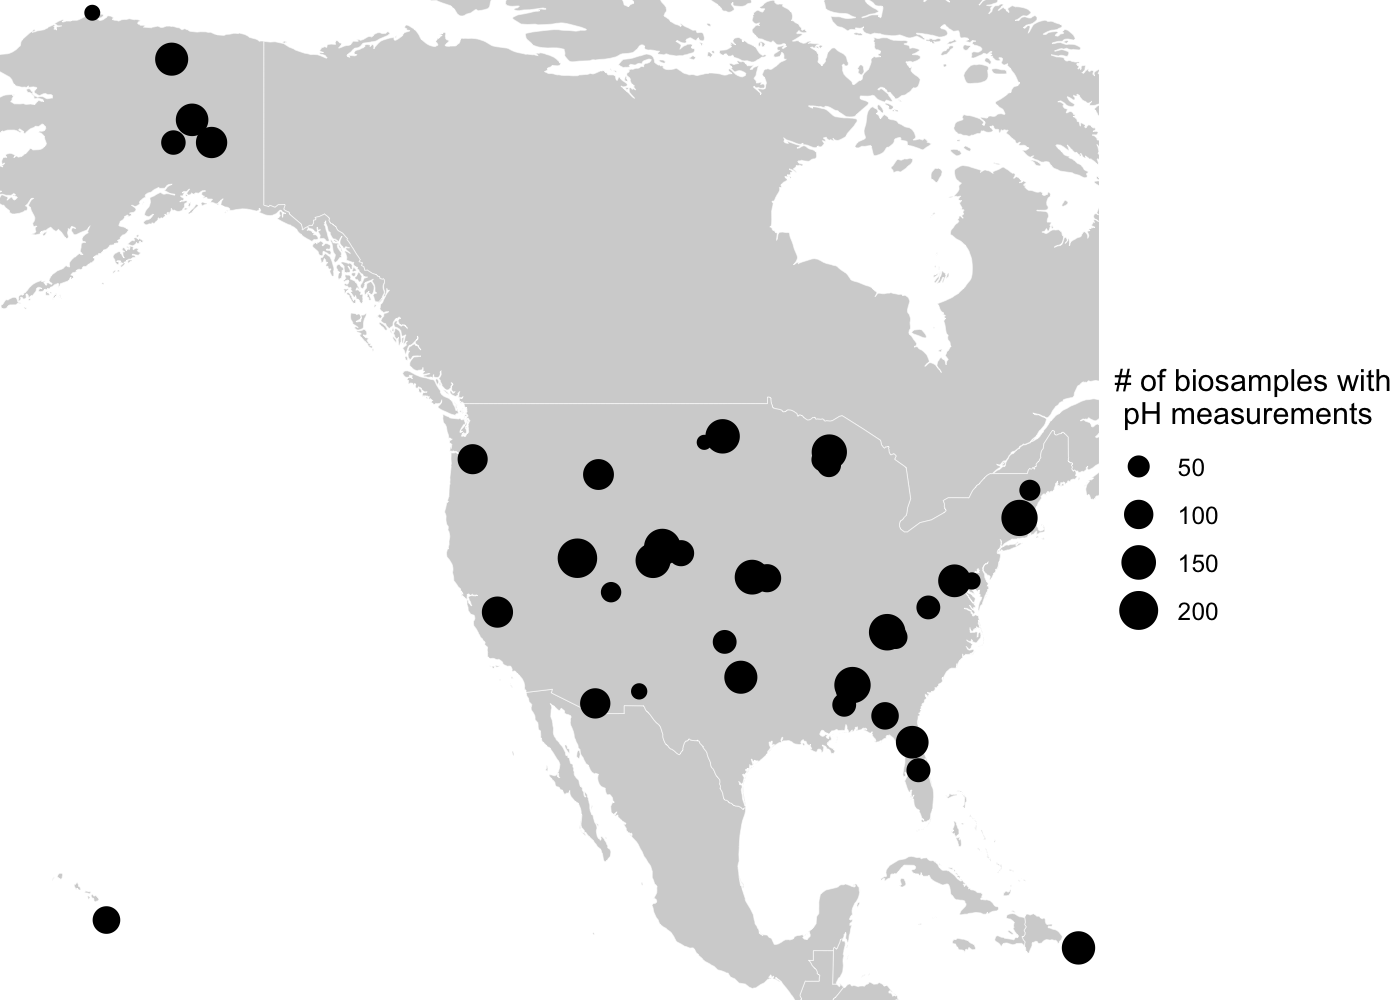

In [6]:
# Prepare location df data
loc_sum_df <- df %>%
  filter(!(is.na(ph))) %>%
  group_by(
    geo_loc,
    env_medium
    ) %>%
  mutate(
    count_with_ph = n(),
    lat_med = median(lat_lon_latitude),
    long_med = median(lat_lon_longitude),
    ) %>%
  select(
    geo_loc, 
    env_medium,
    lat_med,
    long_med,
    count_with_ph
    ) %>%
  distinct()

#Plot summary data
my_theme <- theme_bw()
world <- map_data("world")
g2 <- suppressWarnings(ggplot() +
  geom_map(
    data = world, 
    map = world,
    aes(long, lat, map_id = region),
    color = "white", fill = "lightgray", size = 0.1
  )  +
    geom_point(
        data = loc_sum_df,
        aes(long_med, lat_med,
        size = count_with_ph)) +
    theme_void() +
    labs(size = "# of biosamples with \n pH measurements")+
    coord_cartesian(xlim = c(-165, -65), ylim = c(15, 72), expand = FALSE))

options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 200)
g2


## Plot full time series of pH at the six sites with the most biosamples


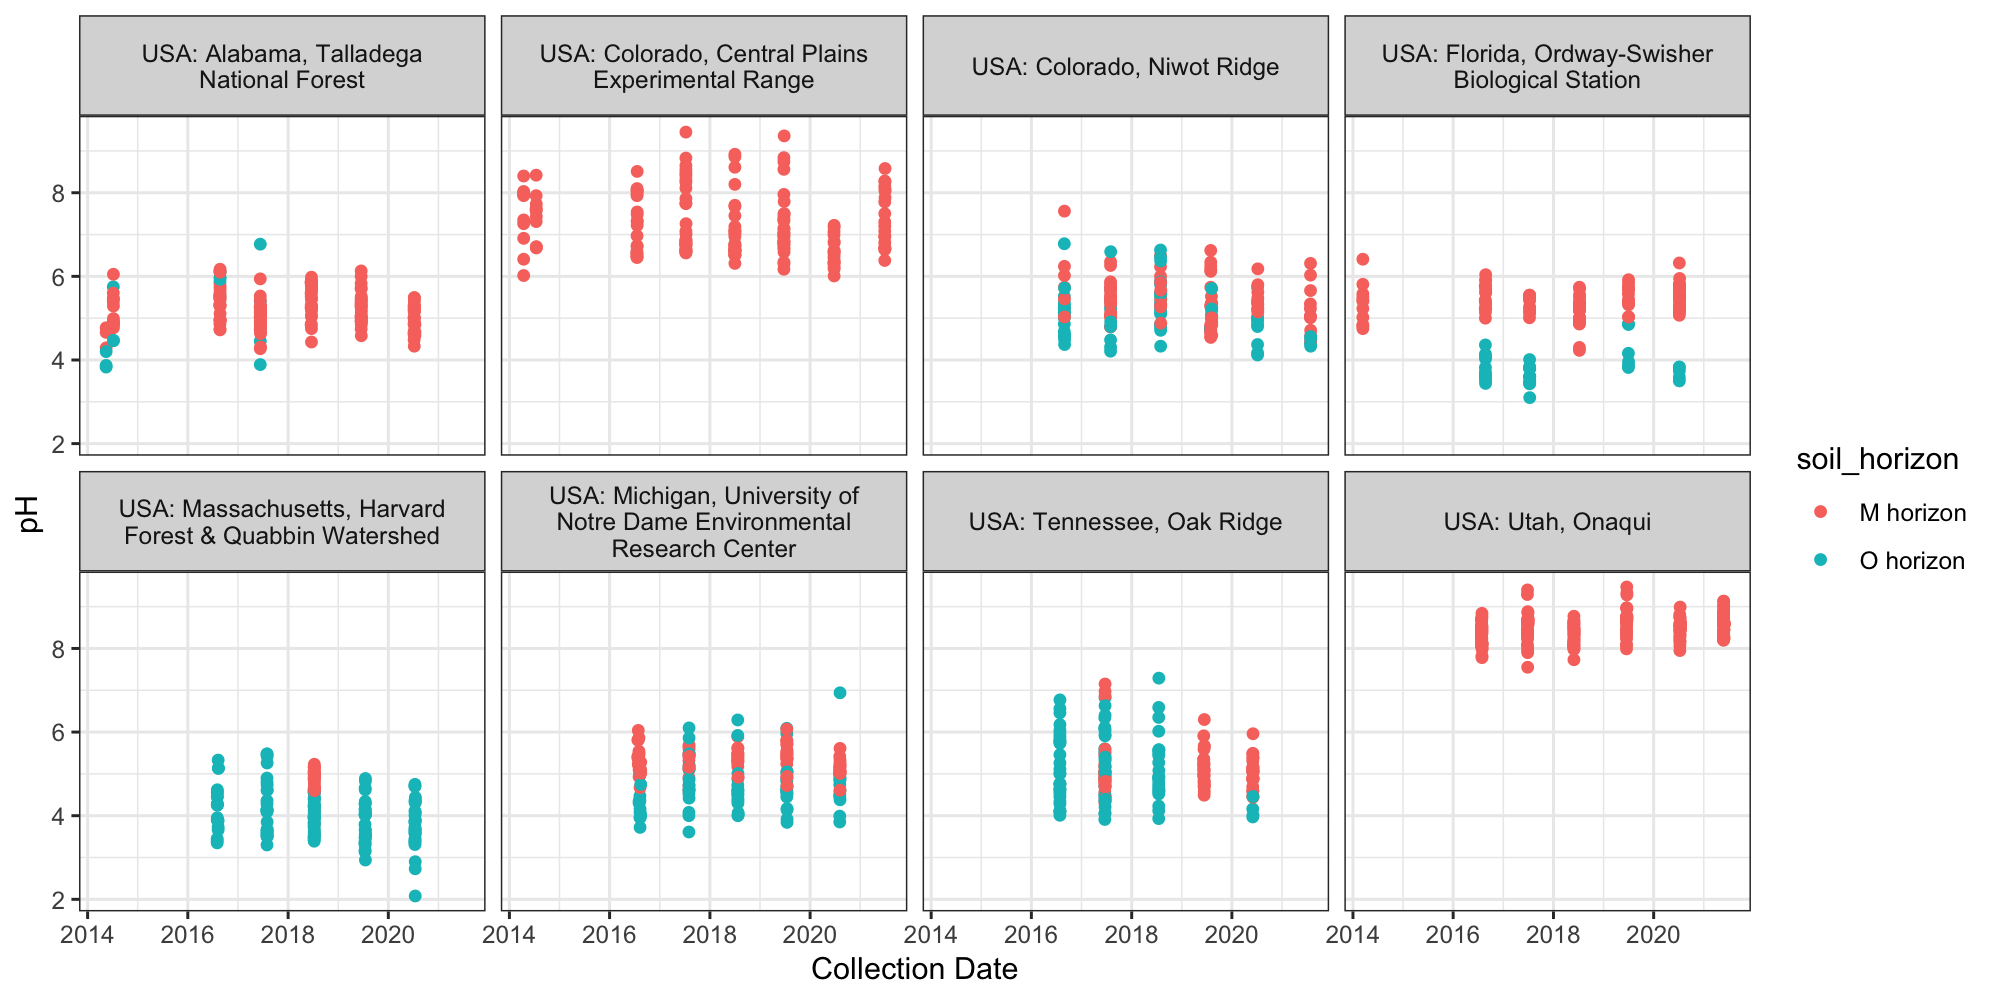

In [7]:
# Prep dataframe with new column of factored sites
df2 <- df %>%
  mutate(geo_loc_grouped = geo_loc %>% 
           factor() %>% 
           fct_lump(n = 8)
         ) %>%
  filter(geo_loc_grouped != "Other")


# Plot data
g <- suppressWarnings(ggplot(data = na.omit(df2)) +
    geom_point(aes(x=collection_date, y = ph, color = soil_horizon)) +
    my_theme +
    scale_x_date()+
    labs(x = "Collection Date", y = "pH")+
    facet_wrap(facets = vars(geo_loc_grouped),
               labeller = label_wrap_gen(width=30),
              nrow = 2))
options(repr.plot.width = 10, repr.plot.height = 5)
g



## Plot full time series of water content at the six sites with the most biosamples


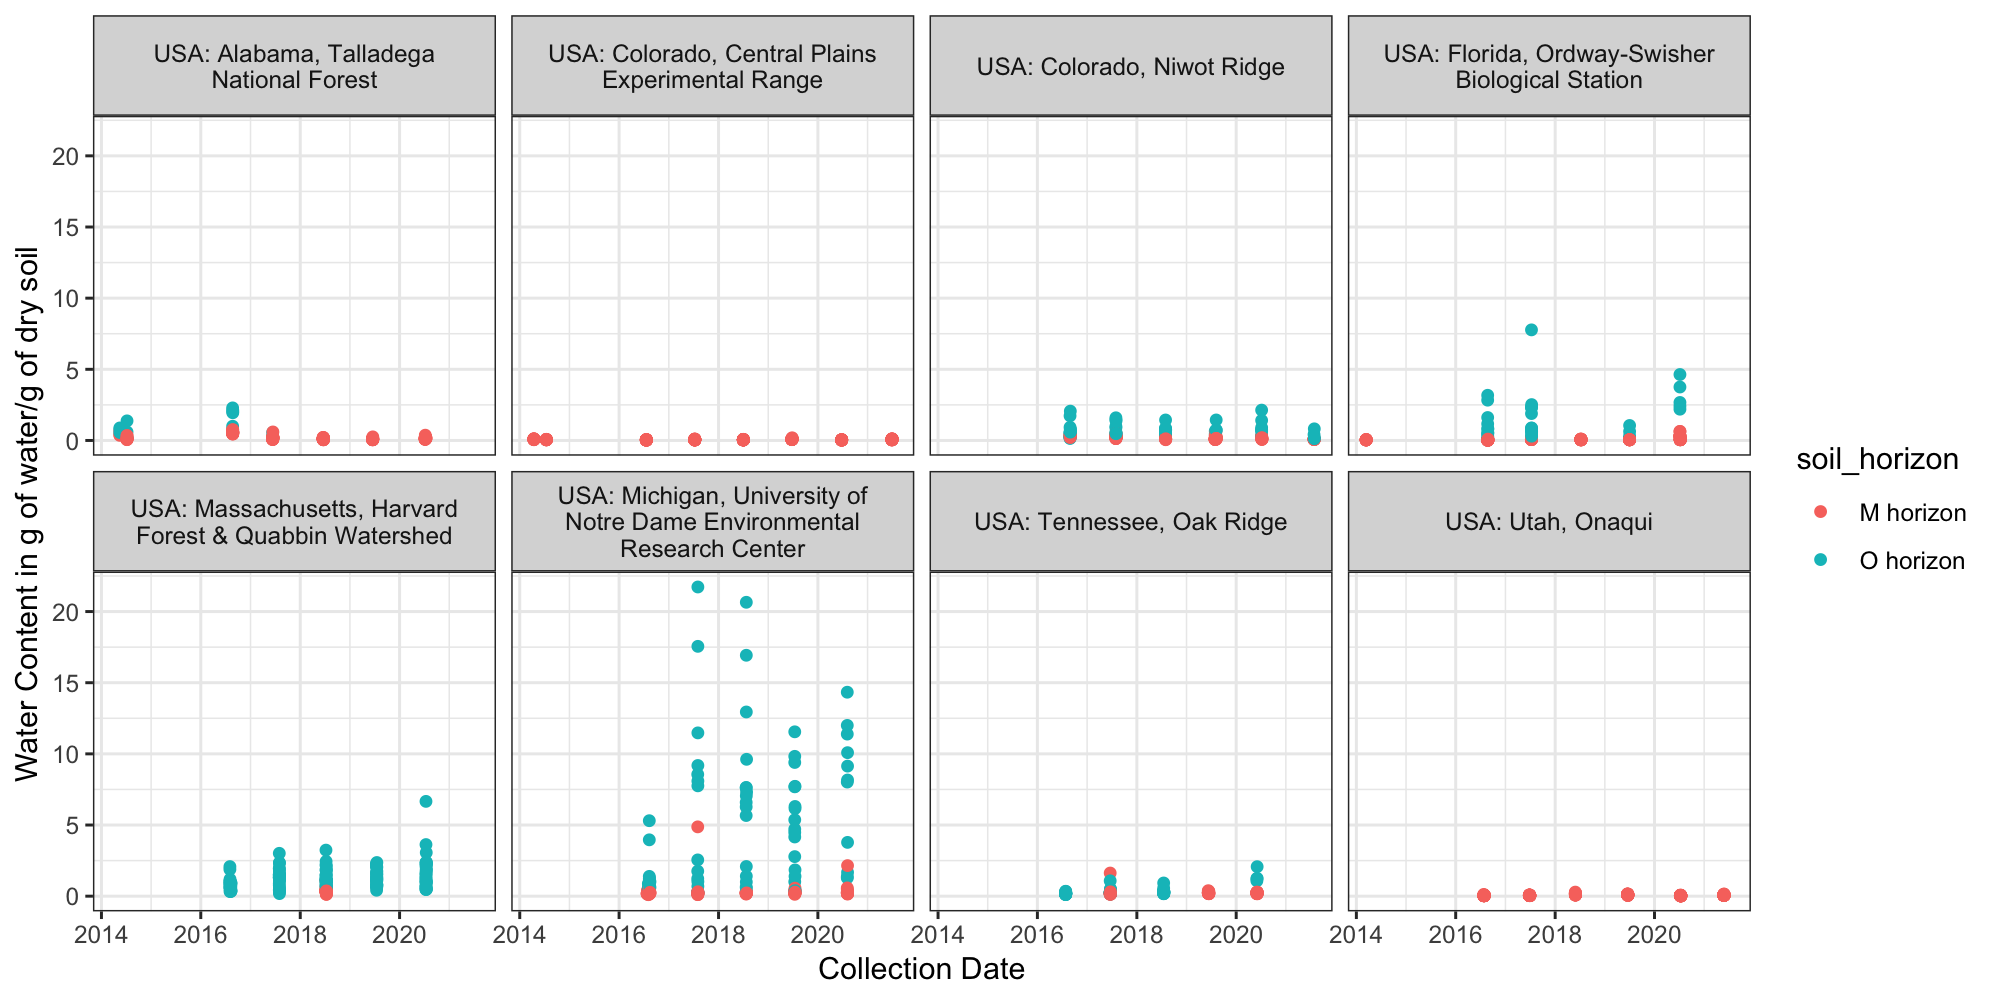

In [8]:
# Plot data
g <- ggplot(data = na.omit(df2)) +
    geom_point(aes(x=collection_date, y = water_content, color = soil_horizon)) +
    my_theme +
    scale_x_date()+
    labs(x = "Collection Date", y = "Water Content in g of water/g of dry soil")+
    facet_wrap(facets = vars(geo_loc_grouped),
               labeller = label_wrap_gen(width=30),
              nrow = 2) 
g